In [ ]:
# Install kaggle
!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()  # Upload file kaggle.json Anda

# Setup kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d ardaputra/palm-oil-seg
!unzip palm-oil-seg.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ardaputra/palm-oil-seg
License(s): unknown
 99% 174M/177M [00:01<00:00, 96.4MB/s]
100% 177M/177M [00:01<00:00, 105MB/s] 
Archive:  palm-oil-seg.zip
  inflating: data.yaml               
  inflating: palm-oil-seg/palm-oil-seg/test/images/44000_16000_100_1471_jpg.rf.b155ea6db69b5f5bf663d4f22ac49abc.jpg  
  inflating: palm-oil-seg/palm-oil-seg/test/images/44000_16000_1048_1639_jpg.rf.cbbaed8d3f83bff6fed2ffc4843e08ff.jpg  
  inflating: palm-oil-seg/palm-oil-seg/test/images/44000_16000_1059_3696_jpg.rf.cf686af5a26b150598ec6bdc6070b0d4.jpg  
  inflating: palm-oil-seg/palm-oil-seg/test/images/44000_16000_105_3843_jpg.rf.462906eddf2323df6632ad677c8ec7bd.jpg  
  inflating: palm-oil-seg/palm-oil-seg/test/images/44000_16000_1060_351_jpg.rf.66759af0c04f22dd19d381ddb88e3dcc.jpg  
  inflating: palm-oil-seg/palm-oil-seg/test/images/44000_16000_1065_1216_jpg.rf.1355d8ed6cf3444351d6d668da77c0fd.jpg  
  inflating: palm-oil-se

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    """
    Load and preprocess image
    Args:
        image_path: Path to image file
        target_size: Desired output size (height, width)
    Returns:
        Preprocessed image array
    """
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize
    img = cv2.resize(img, target_size)

    # Normalize to [0,1]
    img = img.astype(np.float32) / 255.0

    return img

def process_label_file(label_path, width, height):
    """
    Convert polygon coordinates to binary mask
    Args:
        label_path: Path to label file
        width: Target width for the mask
        height: Target height for the mask
    Returns:
        Binary mask of shape (height, width)
    """
    # Create empty mask
    mask = np.zeros((height, width), dtype=np.uint8)

    # Read label file
    with open(label_path, 'r') as f:
        label_data = f.read()

    # Process each line (polygon) in the label file
    for line in label_data.strip().split('\n'):
        if not line:
            continue

        # Parse coordinates
        coords = line.strip().split()
        class_id = int(coords[0])  # Should be 0 in this case

        # Convert normalized coordinates to pixel coordinates
        polygon_coords = []
        for i in range(1, len(coords), 2):
            x = float(coords[i]) * width
            y = float(coords[i + 1]) * height
            polygon_coords.append([x, y])

        # Convert to numpy array
        polygon_coords = np.array(polygon_coords, dtype=np.int32)

        # Draw filled polygon
        cv2.fillPoly(mask, [polygon_coords], 1)

    return mask

def create_dataset(image_dir, label_dir, target_size=(256, 256)):
    """
    Create dataset from images and labels
    Args:
        image_dir: Directory containing images
        label_dir: Directory containing label files
        target_size: Desired output size (height, width)
    Returns:
        X: Image array of shape (n_samples, height, width, channels)
        y: Mask array of shape (n_samples, height, width)
    """
    images = []
    masks = []

    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    for img_file in image_files:
        # Get corresponding label file
        label_file = os.path.splitext(img_file)[0] + '.txt'

        if not os.path.exists(os.path.join(label_dir, label_file)):
            print(f"Warning: No label file found for {img_file}")
            continue

        # Load and preprocess image
        img = load_and_preprocess_image(
            os.path.join(image_dir, img_file),
            target_size
        )

        # Process label file
        mask = process_label_file(
            os.path.join(label_dir, label_file),
            target_size[1],
            target_size[0]
        )

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

def create_unet_model(input_shape):
    """Modified U-Net with reduced complexity"""
    inputs = layers.Input(input_shape)

    # Encoder (reduced filters)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.concatenate([layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(up5)

    up6 = layers.concatenate([layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv5), conv2], axis=3)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(up6)

    up7 = layers.concatenate([layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv6), conv1], axis=3)
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(up7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def main():
    # Set parameters
    IMAGE_DIR = '/content/palm-oil-seg/palm-oil-seg/train/images'
    LABEL_DIR = '/content/palm-oil-seg/palm-oil-seg/train/labels'
    TARGET_SIZE = (256, 256)
    BATCH_SIZE = 16  # Increased batch size
    EPOCHS = 20      # Reduced epochs

    # Create dataset
    X, y = create_dataset(IMAGE_DIR, LABEL_DIR, TARGET_SIZE)

    # Split dataset
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Expand dimensions of masks for training
    y_train = np.expand_dims(y_train, axis=-1)
    y_val = np.expand_dims(y_val, axis=-1)

    # Create callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )

    # Create and train model
    model = create_unet_model((TARGET_SIZE[0], TARGET_SIZE[1], 3))

    # Train with callbacks
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr]
    )

    # Save model
    model.save('palm_tree_detector.h5')

    return history

if __name__ == '__main__':
    history = main()

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1570s 23s/step - accuracy: 0.6681 - loss: 0.5739 - val_accuracy: 0.8726 - val_loss: 0.3039 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1584s 23s/step - accuracy: 0.8851 - loss: 0.2768 - val_accuracy: 0.9052 - val_loss: 0.2267 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1566s 23s/step - accuracy: 0.9158 - loss: 0.2045 - val_accuracy: 0.9318 - val_loss: 0.1633 - learning_rate: 0.0010
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1572s 23s/step - accuracy: 0.9345 - loss: 0.1572 - val_accuracy: 0.9405 - val_loss: 0.1423 - learning_rate: 0.0010
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1579s 23s/step - accuracy: 0.9423 - loss: 0.1381 - val_accuracy: 0.9441 - val_loss: 0.1351 - learning_rate: 0.0010
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1592s 23s/step - accuracy: 0.9473 - loss: 0.1257 - val_accuracy: 0.9454 - val_loss: 0.1309 - learning_rate: 0.0010
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1540s 23s/step - accuracy: 0.9500 - loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


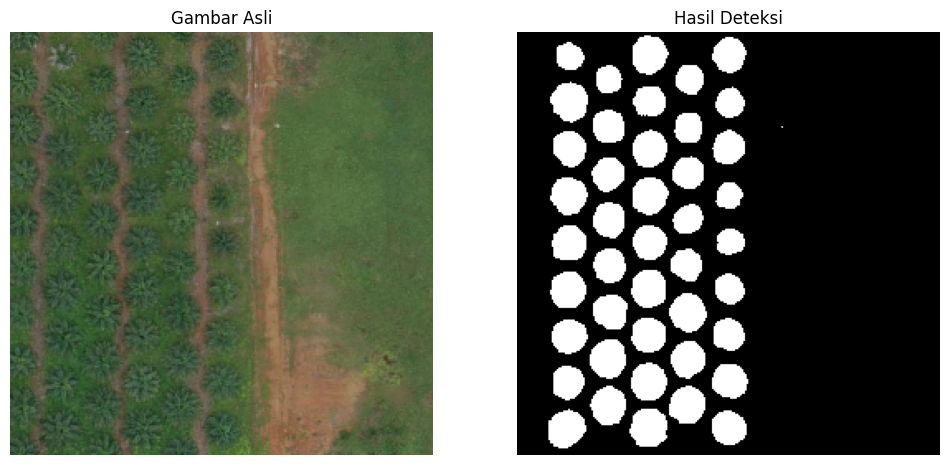

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    """
    Load dan preprocess gambar
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Tidak dapat memuat gambar di {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0

    return img

def predict_palm_trees(model_path, image_path, target_size=(256, 256)):
    """
    Melakukan prediksi segmentasi kelapa sawit
    """
    # Load model
    model = tf.keras.models.load_model(model_path)

    # Load dan preprocess gambar
    img = load_and_preprocess_image(image_path, target_size)

    # Prediksi
    img_batch = np.expand_dims(img, axis=0)
    pred_mask = model.predict(img_batch)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    return img, pred_mask[0, :, :, 0]

def display_results(image, mask):
    """
    Menampilkan hasil prediksi
    """
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Gambar Asli')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Hasil Deteksi')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.show()

# Path ke model dan folder test
MODEL_PATH = '/content/palm_tree_detector.h5'
TEST_DIR = '/content/palm-oil-seg/palm-oil-seg/test/images'

# Contoh penggunaan untuk satu gambar dari folder test
test_images = [f for f in os.listdir(TEST_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))]

if test_images:
    # Ambil gambar pertama sebagai contoh
    test_image_path = os.path.join(TEST_DIR, test_images[0])

    # Lakukan prediksi
    image, predicted_mask = predict_palm_trees(MODEL_PATH, test_image_path)

    # Tampilkan hasil
    display_results(image, predicted_mask)
else:
    print("Tidak ada gambar test yang ditemukan")

# Untuk memprediksi semua gambar dalam folder test
def predict_all_images():
    for img_name in test_images:
        print(f"Memproses gambar: {img_name}")
        image_path = os.path.join(TEST_DIR, img_name)
        image, predicted_mask = predict_palm_trees(MODEL_PATH, image_path)
        display_results(image, predicted_mask)

# Uncomment baris di bawah ini untuk memprediksi semua gambar
# predict_all_images()

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    """
    Load dan preprocess gambar
    Args:
        image_path: Path ke file gambar
        target_size: Ukuran output yang diinginkan (height, width)
    Returns:
        Gambar yang sudah dipreprocess
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Tidak dapat memuat gambar di {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0

    return img

def predict_palm_trees(model_path, image_path, target_size=(256, 256)):
    """
    Melakukan prediksi segmentasi kelapa sawit
    Args:
        model_path: Path ke model (.h5)
        image_path: Path ke gambar yang akan diprediksi
        target_size: Ukuran gambar yang diinginkan
    Returns:
        Gambar asli dan mask hasil prediksi
    """
    # Load model
    model = tf.keras.models.load_model(model_path)

    # Load dan preprocess gambar
    img = load_and_preprocess_image(image_path, target_size)

    # Prediksi
    img_batch = np.expand_dims(img, axis=0)
    pred_mask = model.predict(img_batch)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    return img, pred_mask[0, :, :, 0]

def display_results(image, mask):
    """
    Menampilkan gambar asli dan hasil prediksi
    Args:
        image: Gambar asli
        mask: Mask hasil prediksi
    """
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Gambar Asli')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Hasil Deteksi')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.show()

def calculate_palm_area(mask):
    """
    Menghitung persentase area kelapa sawit dalam gambar
    Args:
        mask: Mask hasil prediksi
    Returns:
        Persentase area kelapa sawit
    """
    total_pixels = mask.shape[0] * mask.shape[1]
    palm_pixels = np.sum(mask)
    percentage = (palm_pixels / total_pixels) * 100
    return percentage

def predict_and_save_results_with_stats(model_path, test_dir, save_dir='predicted_results'):
    """
    Melakukan prediksi pada semua gambar dan menyimpan hasilnya dengan statistik
    Args:
        model_path: Path ke model
        test_dir: Direktori yang berisi gambar test
        save_dir: Direktori untuk menyimpan hasil
    """
    # Buat direktori untuk menyimpan hasil
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Ambil daftar gambar test
    test_images = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    results = []

    print(f"Ditemukan {len(test_images)} gambar untuk dianalisis")

    for img_name in test_images:
        print(f"\nMemproses gambar: {img_name}")
        image_path = os.path.join(test_dir, img_name)

        try:
            # Prediksi
            image, predicted_mask = predict_palm_trees(model_path, image_path)

            # Hitung persentase area
            palm_percentage = calculate_palm_area(predicted_mask)
            results.append({
                'image': img_name,
                'palm_area_percentage': palm_percentage
            })

            # Buat visualisasi
            plt.figure(figsize=(12, 6))

            plt.subplot(1, 2, 1)
            plt.title('Gambar Asli')
            plt.imshow(image)
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title(f'Hasil Deteksi\n(Area Kelapa Sawit: {palm_percentage:.1f}%)')
            plt.imshow(predicted_mask, cmap='gray')
            plt.axis('off')

            # Simpan hasil
            save_path = os.path.join(save_dir, f'result_{img_name}')
            plt.savefig(save_path)
            plt.close()

            print(f"Area Kelapa Sawit: {palm_percentage:.1f}%")
            print(f"Hasil disimpan di: {save_path}")

        except Exception as e:
            print(f"Error saat memproses {img_name}: {str(e)}")

    # Tampilkan ringkasan
    print("\n=== Ringkasan Hasil ===")
    total_area = 0
    for result in results:
        print(f"Gambar: {result['image']}")
        print(f"Area Kelapa Sawit: {result['palm_area_percentage']:.1f}%\n")
        total_area += result['palm_area_percentage']

    if results:
        avg_area = total_area / len(results)
        print(f"\nRata-rata area kelapa sawit: {avg_area:.1f}%")

        # Simpan ringkasan ke file
        summary_path = os.path.join(save_dir, 'summary.txt')
        with open(summary_path, 'w') as f:
            f.write("=== Ringkasan Analisis Kelapa Sawit ===\n\n")
            for result in results:
                f.write(f"Gambar: {result['image']}\n")
                f.write(f"Area Kelapa Sawit: {result['palm_area_percentage']:.1f}%\n\n")
            f.write(f"\nRata-rata area kelapa sawit: {avg_area:.1f}%")

        print(f"\nRingkasan lengkap disimpan di: {summary_path}")

# Path ke model dan direktori test
MODEL_PATH = '/content/palm_tree_detector.h5'
TEST_DIR = '/content/palm-oil-seg/palm-oil-seg/test/images'

# Jalankan analisis
predict_and_save_results_with_stats(MODEL_PATH, TEST_DIR)

Ditemukan 230 gambar untuk dianalisis

Memproses gambar: 44000_16000_3001_1747_jpg.rf.95813f0ee25b6e75a4138c94bfedb3e6.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


Area Kelapa Sawit: 22.1%
Hasil disimpan di: predicted_results/result_44000_16000_3001_1747_jpg.rf.95813f0ee25b6e75a4138c94bfedb3e6.jpg

Memproses gambar: 52000_20000_769_1551_jpg.rf.9e0d687b970b91a9aa54d25bdde3a93f.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


Area Kelapa Sawit: 24.0%
Hasil disimpan di: predicted_results/result_52000_20000_769_1551_jpg.rf.9e0d687b970b91a9aa54d25bdde3a93f.jpg

Memproses gambar: 52000_20000_3233_1477_jpg.rf.19e59d4ef94266f0646b9eaa323a315b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Area Kelapa Sawit: 59.3%
Hasil disimpan di: predicted_results/result_52000_20000_3233_1477_jpg.rf.19e59d4ef94266f0646b9eaa323a315b.jpg

Memproses gambar: 52000_20000_2222_3458_jpg.rf.4c364c3a40ebca29495e2c2113dc4940.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


Area Kelapa Sawit: 38.2%
Hasil disimpan di: predicted_results/result_52000_20000_2222_3458_jpg.rf.4c364c3a40ebca29495e2c2113dc4940.jpg

Memproses gambar: 52000_20000_594_528_jpg.rf.7bc7c840c68a012895a1e2cc3de5c666.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


Area Kelapa Sawit: 64.0%
Hasil disimpan di: predicted_results/result_52000_20000_594_528_jpg.rf.7bc7c840c68a012895a1e2cc3de5c666.jpg

Memproses gambar: 44000_4000_1108_197_jpg.rf.79c0ce222b58438e5893e7379317071e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
Area Kelapa Sawit: 45.5%
Hasil disimpan di: predicted_results/result_44000_4000_1108_197_jpg.rf.79c0ce222b58438e5893e7379317071e.jpg

Memproses gambar: 44000_16000_349_1078_jpg.rf.6a20bfa34b285ba30ac1a3063c7c7258.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
Area Kelapa Sawit: 57.5%
Hasil disimpan di: predicted_results/result_44000_16000_349_1078_jpg.rf.6a20bfa34b285ba30ac1a3063c7c7258.jpg

Memproses gambar: 44000_4000_2180_278_jpg.rf.7c26192b1a82d5013a03dc17b40281cb.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
Area Kelapa Sawit: 46.5%
Hasil disimpan di: predicted_results/result_44000_4000_2180_278_jpg.rf.7c26192b1a82d5013a03dc17b40281cb.jpg

Memproses gambar: 52000_20000_3057_1642_jpg.rf.634118e529231d57f74fd6bff09d8996.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


Area Kelapa Sawit: 45.5%
Hasil disimpan di: predicted_results/result_52000_20000_3057_1642_jpg.rf.634118e529231d57f74fd6bff09d8996.jpg

Memproses gambar: 44000_4000_3286_200_jpg.rf.d1c9813ac68e29ccac93ae119b9c8b06.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


Area Kelapa Sawit: 43.6%
Hasil disimpan di: predicted_results/result_44000_4000_3286_200_jpg.rf.d1c9813ac68e29ccac93ae119b9c8b06.jpg

Memproses gambar: 52000_20000_3668_1509_jpg.rf.bc1cda6ccb1c73bb99d6061337a30ace.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


Area Kelapa Sawit: 68.1%
Hasil disimpan di: predicted_results/result_52000_20000_3668_1509_jpg.rf.bc1cda6ccb1c73bb99d6061337a30ace.jpg

Memproses gambar: 52000_20000_1878_863_jpg.rf.e2cbf7c970a880a99c2b807394c2c69f.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


Area Kelapa Sawit: 36.2%
Hasil disimpan di: predicted_results/result_52000_20000_1878_863_jpg.rf.e2cbf7c970a880a99c2b807394c2c69f.jpg

Memproses gambar: 44000_4000_2672_1380_jpg.rf.014f6d8327f404782384685477338004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


Area Kelapa Sawit: 39.8%
Hasil disimpan di: predicted_results/result_44000_4000_2672_1380_jpg.rf.014f6d8327f404782384685477338004.jpg

Memproses gambar: 44000_16000_349_1172_jpg.rf.02f50b5da282cb1d73901e1622cda722.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


Area Kelapa Sawit: 58.6%
Hasil disimpan di: predicted_results/result_44000_16000_349_1172_jpg.rf.02f50b5da282cb1d73901e1622cda722.jpg

Memproses gambar: 44000_4000_2560_3246_jpg.rf.b142f98bad0f49d40f0125abbdac4401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


Area Kelapa Sawit: 44.8%
Hasil disimpan di: predicted_results/result_44000_4000_2560_3246_jpg.rf.b142f98bad0f49d40f0125abbdac4401.jpg

Memproses gambar: 44000_4000_392_3443_jpg.rf.e939eb8c609da7a0145b0e0c050fd348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


Area Kelapa Sawit: 25.9%
Hasil disimpan di: predicted_results/result_44000_4000_392_3443_jpg.rf.e939eb8c609da7a0145b0e0c050fd348.jpg

Memproses gambar: 52000_20000_2773_1031_jpg.rf.60e829620ea02a72c64cef24fd2b062b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


Area Kelapa Sawit: 37.6%
Hasil disimpan di: predicted_results/result_52000_20000_2773_1031_jpg.rf.60e829620ea02a72c64cef24fd2b062b.jpg

Memproses gambar: 44000_16000_2165_3255_jpg.rf.4cae67bcfe5c8496a025fc38000a40ff.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


Area Kelapa Sawit: 44.1%
Hasil disimpan di: predicted_results/result_44000_16000_2165_3255_jpg.rf.4cae67bcfe5c8496a025fc38000a40ff.jpg

Memproses gambar: 44000_16000_2112_1601_jpg.rf.4145e7f959e90320628548b5d99671ac.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


Area Kelapa Sawit: 51.1%
Hasil disimpan di: predicted_results/result_44000_16000_2112_1601_jpg.rf.4145e7f959e90320628548b5d99671ac.jpg

Memproses gambar: 44000_16000_1556_537_jpg.rf.75d5602d60510402aee1de364d61f883.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
Area Kelapa Sawit: 40.0%
Hasil disimpan di: predicted_results/result_44000_16000_1556_537_jpg.rf.75d5602d60510402aee1de364d61f883.jpg

Memproses gambar: 44000_4000_2694_3829_jpg.rf.033381d7b1c385360ee69ff0f78fd511.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
Area Kelapa Sawit: 53.8%
Hasil disimpan di: predicted_results/result_44000_4000_2694_3829_jpg.rf.033381d7b1c385360ee69ff0f78fd511.jpg

Memproses gambar: 44000_4000_83_803_jpg.rf.85049bb3fc1dcf77ec92365da0ed4237.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
Area Kelapa Sawit: 47.8%
Hasil disimpan di: predicted_results/result_44000_4000_83_803_jpg.rf.85049bb3fc1dcf77ec92365da0ed4237.jpg

Memproses gambar: 52000_20000_663_3898_jpg.rf.cf2993d85e6e3085906fbf4453ad79e0.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


Area Kelapa Sawit: 39.2%
Hasil disimpan di: predicted_results/result_52000_20000_663_3898_jpg.rf.cf2993d85e6e3085906fbf4453ad79e0.jpg

Memproses gambar: 44000_16000_3667_3895_jpg.rf.38ae49fb6818c530ff89ab7453a3eafb.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


Area Kelapa Sawit: 43.9%
Hasil disimpan di: predicted_results/result_44000_16000_3667_3895_jpg.rf.38ae49fb6818c530ff89ab7453a3eafb.jpg

Memproses gambar: 44000_4000_2570_2038_jpg.rf.eaa31e2d2ea5f7330912bbb11de853a7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


Area Kelapa Sawit: 36.6%
Hasil disimpan di: predicted_results/result_44000_4000_2570_2038_jpg.rf.eaa31e2d2ea5f7330912bbb11de853a7.jpg

Memproses gambar: 44000_16000_259_3839_jpg.rf.302aa4c5075af730bdc0c5728efd9448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


Area Kelapa Sawit: 52.3%
Hasil disimpan di: predicted_results/result_44000_16000_259_3839_jpg.rf.302aa4c5075af730bdc0c5728efd9448.jpg

Memproses gambar: 52000_20000_688_929_jpg.rf.536be14ee0492b9ab29979f7cfdf466d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


Area Kelapa Sawit: 50.8%
Hasil disimpan di: predicted_results/result_52000_20000_688_929_jpg.rf.536be14ee0492b9ab29979f7cfdf466d.jpg

Memproses gambar: 44000_16000_105_3843_jpg.rf.462906eddf2323df6632ad677c8ec7bd.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


Area Kelapa Sawit: 51.1%
Hasil disimpan di: predicted_results/result_44000_16000_105_3843_jpg.rf.462906eddf2323df6632ad677c8ec7bd.jpg

Memproses gambar: 52000_20000_1114_1425_jpg.rf.971567ee204ecc8c51b8379d78d9dbe5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


Area Kelapa Sawit: 33.3%
Hasil disimpan di: predicted_results/result_52000_20000_1114_1425_jpg.rf.971567ee204ecc8c51b8379d78d9dbe5.jpg

Memproses gambar: 44000_4000_646_2704_jpg.rf.4e74c3e2bcee4cc3ae5f3b5aae41f79e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


Area Kelapa Sawit: 47.9%
Hasil disimpan di: predicted_results/result_44000_4000_646_2704_jpg.rf.4e74c3e2bcee4cc3ae5f3b5aae41f79e.jpg

Memproses gambar: 44000_4000_1324_946_jpg.rf.cb516178ecb58445a402da0dd59de67f.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


Area Kelapa Sawit: 46.5%
Hasil disimpan di: predicted_results/result_44000_4000_1324_946_jpg.rf.cb516178ecb58445a402da0dd59de67f.jpg

Memproses gambar: 44000_4000_3630_1225_jpg.rf.83997fe04d02fbe45a13a28033f509ba.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


Area Kelapa Sawit: 54.0%
Hasil disimpan di: predicted_results/result_44000_4000_3630_1225_jpg.rf.83997fe04d02fbe45a13a28033f509ba.jpg

Memproses gambar: 44000_16000_60_683_jpg.rf.cc57d71386ec507ca7dfdfc910fdbbbb.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
Area Kelapa Sawit: 55.7%
Hasil disimpan di: predicted_results/result_44000_16000_60_683_jpg.rf.cc57d71386ec507ca7dfdfc910fdbbbb.jpg

Memproses gambar: 52000_20000_2382_2058_jpg.rf.7d29afb26df668cfa0dc07661e1d20f2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
Area Kelapa Sawit: 10.5%
Hasil disimpan di: predicted_results/result_52000_20000_2382_2058_jpg.rf.7d29afb26df668cfa0dc07661e1d20f2.jpg

Memproses gambar: 52000_20000_3520_687_jpg.rf.d9de50caef79da18d35e4232260423f2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
Area Kelapa Sawit: 61.0%
Hasil disimpan di: predicted_results/result_52000_20000_3520_687_jpg.rf.d9de50caef79da18d35e4232260423f2.jpg

Memproses gambar: 44000_16000_1990_1413_jpg.rf.da0c692e2c038fa3f378be319d88aeec.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
Area Kelapa Sawit: 61.6%
Hasil disimpan di: predicted_results/result_44000_16000_1990_1413_jpg.rf.da0c692e2c038fa3f378be319d88aeec.jpg

Memproses gambar: 44000_4000_2130_1484_jpg.rf.98ac9dc7c363c1f51743a6a50cf35cde.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


Area Kelapa Sawit: 36.1%
Hasil disimpan di: predicted_results/result_44000_4000_2130_1484_jpg.rf.98ac9dc7c363c1f51743a6a50cf35cde.jpg

Memproses gambar: 52000_20000_2697_105_jpg.rf.e400be4e5b4e164ddb35258f0f6f206a.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Area Kelapa Sawit: 69.9%
Hasil disimpan di: predicted_results/result_52000_20000_2697_105_jpg.rf.e400be4e5b4e164ddb35258f0f6f206a.jpg

Memproses gambar: 44000_16000_2499_708_jpg.rf.01e01f086346b229f246062f24bcb417.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


Area Kelapa Sawit: 15.7%
Hasil disimpan di: predicted_results/result_44000_16000_2499_708_jpg.rf.01e01f086346b229f246062f24bcb417.jpg

Memproses gambar: 44000_4000_1224_2756_jpg.rf.5077c3e084c6bcab6dbfb7d2267092c2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


Area Kelapa Sawit: 41.1%
Hasil disimpan di: predicted_results/result_44000_4000_1224_2756_jpg.rf.5077c3e084c6bcab6dbfb7d2267092c2.jpg

Memproses gambar: 52000_20000_2674_2102_jpg.rf.9c696380c12b0a6e9d716645d2441e33.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


Area Kelapa Sawit: 12.9%
Hasil disimpan di: predicted_results/result_52000_20000_2674_2102_jpg.rf.9c696380c12b0a6e9d716645d2441e33.jpg

Memproses gambar: 44000_4000_274_1822_jpg.rf.fb0f65329ec50045b86a2db2e4e7e556.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


Area Kelapa Sawit: 45.3%
Hasil disimpan di: predicted_results/result_44000_4000_274_1822_jpg.rf.fb0f65329ec50045b86a2db2e4e7e556.jpg

Memproses gambar: 52000_20000_1657_3348_jpg.rf.26bfa8a386bce68d02566cbcfc8eac0e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


Area Kelapa Sawit: 33.5%
Hasil disimpan di: predicted_results/result_52000_20000_1657_3348_jpg.rf.26bfa8a386bce68d02566cbcfc8eac0e.jpg

Memproses gambar: 52000_20000_3117_2540_jpg.rf.8e3d01008b293e8956c2812979833ad0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


Area Kelapa Sawit: 35.3%
Hasil disimpan di: predicted_results/result_52000_20000_3117_2540_jpg.rf.8e3d01008b293e8956c2812979833ad0.jpg

Memproses gambar: 44000_16000_2225_1397_jpg.rf.ad97db101daa4d4ee5e9eef5a032b742.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


Area Kelapa Sawit: 46.7%
Hasil disimpan di: predicted_results/result_44000_16000_2225_1397_jpg.rf.ad97db101daa4d4ee5e9eef5a032b742.jpg

Memproses gambar: 52000_20000_1528_1667_jpg.rf.2965a38bf6e4c35a13a0309e571ea5ce.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


Area Kelapa Sawit: 17.9%
Hasil disimpan di: predicted_results/result_52000_20000_1528_1667_jpg.rf.2965a38bf6e4c35a13a0309e571ea5ce.jpg

Memproses gambar: 52000_20000_2581_2480_jpg.rf.455c625277a0c556700e20415624d9ca.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
Area Kelapa Sawit: 14.1%
Hasil disimpan di: predicted_results/result_52000_20000_2581_2480_jpg.rf.455c625277a0c556700e20415624d9ca.jpg

Memproses gambar: 44000_16000_1347_3635_jpg.rf.82f3ada9687f543123aa350f334df27e.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
Area Kelapa Sawit: 47.3%
Hasil disimpan di: predicted_results/result_44000_16000_1347_3635_jpg.rf.82f3ada9687f543123aa350f334df27e.jpg

Memproses gambar: 44000_4000_2729_897_jpg.rf.7cf4743dee388436d1a1b6de51a82554.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
Area Kelapa Sawit: 39.1%
Hasil disimpan di: predicted_results/result_44000_4000_2729_897_jpg.rf.7cf4743dee388436d1a1b6de51a82554.jpg

Memproses gambar: 44000_4000_48_2214_jpg.rf.36c0566161e49719423b52e72459c8bb.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
Area Kelapa Sawit: 41.5%
Hasil disimpan di: predicted_results/result_44000_4000_48_2214_jpg.rf.36c0566161e49719423b52e72459c8bb.jpg

Memproses gambar: 52000_20000_1405_820_jpg.rf.4eda7019ae5830ed47d28ea24ae46fe3.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


Area Kelapa Sawit: 60.0%
Hasil disimpan di: predicted_results/result_52000_20000_1405_820_jpg.rf.4eda7019ae5830ed47d28ea24ae46fe3.jpg

Memproses gambar: 52000_20000_2786_3272_jpg.rf.7c825c2aeee498658e421bea3a6b78c7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


Area Kelapa Sawit: 31.4%
Hasil disimpan di: predicted_results/result_52000_20000_2786_3272_jpg.rf.7c825c2aeee498658e421bea3a6b78c7.jpg

Memproses gambar: 44000_4000_1176_1891_jpg.rf.cad38ec8914aed29e5de9600ec06c909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


Area Kelapa Sawit: 47.7%
Hasil disimpan di: predicted_results/result_44000_4000_1176_1891_jpg.rf.cad38ec8914aed29e5de9600ec06c909.jpg

Memproses gambar: 44000_4000_1699_643_jpg.rf.7ab036c9d2176b672fea37f1310842b3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


Area Kelapa Sawit: 47.5%
Hasil disimpan di: predicted_results/result_44000_4000_1699_643_jpg.rf.7ab036c9d2176b672fea37f1310842b3.jpg

Memproses gambar: 44000_4000_3379_1207_jpg.rf.71a0a0d78b1b4429a4dcfcadf3b45f98.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


Area Kelapa Sawit: 54.1%
Hasil disimpan di: predicted_results/result_44000_4000_3379_1207_jpg.rf.71a0a0d78b1b4429a4dcfcadf3b45f98.jpg

Memproses gambar: 44000_4000_2611_1354_jpg.rf.cfc40b9834d02172b69acae726591f44.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


Area Kelapa Sawit: 44.2%
Hasil disimpan di: predicted_results/result_44000_4000_2611_1354_jpg.rf.cfc40b9834d02172b69acae726591f44.jpg

Memproses gambar: 44000_16000_2457_3395_jpg.rf.d5da1e08f4339b596430700337fc483e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


Area Kelapa Sawit: 40.2%
Hasil disimpan di: predicted_results/result_44000_16000_2457_3395_jpg.rf.d5da1e08f4339b596430700337fc483e.jpg

Memproses gambar: 44000_16000_2152_1860_jpg.rf.577f9579a521498aa546303df20a52aa.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


Area Kelapa Sawit: 50.8%
Hasil disimpan di: predicted_results/result_44000_16000_2152_1860_jpg.rf.577f9579a521498aa546303df20a52aa.jpg

Memproses gambar: 52000_20000_2423_143_jpg.rf.efe0ccf8f90c17d65be2f8b50750d9e1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


Area Kelapa Sawit: 60.6%
Hasil disimpan di: predicted_results/result_52000_20000_2423_143_jpg.rf.efe0ccf8f90c17d65be2f8b50750d9e1.jpg

Memproses gambar: 44000_4000_2995_2079_jpg.rf.a5e6eb50fdd74e96c86f488733ed9209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


Area Kelapa Sawit: 48.0%
Hasil disimpan di: predicted_results/result_44000_4000_2995_2079_jpg.rf.a5e6eb50fdd74e96c86f488733ed9209.jpg

Memproses gambar: 44000_16000_3224_1362_jpg.rf.66ddb21635459b38bc79efc24eb0d0f1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step


Area Kelapa Sawit: 11.7%
Hasil disimpan di: predicted_results/result_44000_16000_3224_1362_jpg.rf.66ddb21635459b38bc79efc24eb0d0f1.jpg

Memproses gambar: 44000_16000_3218_1217_jpg.rf.c0e7f1c7b7604d7a390580e46af8c78d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
Area Kelapa Sawit: 10.4%
Hasil disimpan di: predicted_results/result_44000_16000_3218_1217_jpg.rf.c0e7f1c7b7604d7a390580e46af8c78d.jpg

Memproses gambar: 44000_4000_3696_2833_jpg.rf.3916e5f18c2754569f47f701f6235f0d.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
Area Kelapa Sawit: 50.2%
Hasil disimpan di: predicted_results/result_44000_4000_3696_2833_jpg.rf.3916e5f18c2754569f47f701f6235f0d.jpg

Memproses gambar: 44000_16000_1060_351_jpg.rf.66759af0c04f22dd19d381ddb88e3dcc.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


Area Kelapa Sawit: 55.6%
Hasil disimpan di: predicted_results/result_44000_16000_1060_351_jpg.rf.66759af0c04f22dd19d381ddb88e3dcc.jpg

Memproses gambar: 44000_4000_2429_2373_jpg.rf.b6d926357a99e1749bd57620c125c287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


Area Kelapa Sawit: 40.7%
Hasil disimpan di: predicted_results/result_44000_4000_2429_2373_jpg.rf.b6d926357a99e1749bd57620c125c287.jpg

Memproses gambar: 52000_20000_3906_1960_jpg.rf.ed84903e5397f7433612cc0ee8973a61.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


Area Kelapa Sawit: 64.2%
Hasil disimpan di: predicted_results/result_52000_20000_3906_1960_jpg.rf.ed84903e5397f7433612cc0ee8973a61.jpg

Memproses gambar: 44000_4000_665_1278_jpg.rf.d3dc9f9a8eaae72c033c9d80034a572b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


Area Kelapa Sawit: 47.2%
Hasil disimpan di: predicted_results/result_44000_4000_665_1278_jpg.rf.d3dc9f9a8eaae72c033c9d80034a572b.jpg

Memproses gambar: 44000_4000_16_2592_jpg.rf.d5ab5b5936090d89f4f030d2c0ba1fbb.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


Area Kelapa Sawit: 48.8%
Hasil disimpan di: predicted_results/result_44000_4000_16_2592_jpg.rf.d5ab5b5936090d89f4f030d2c0ba1fbb.jpg

Memproses gambar: 44000_4000_2449_2835_jpg.rf.a56ac383cbffe9a0371d9a1560eff098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


Area Kelapa Sawit: 43.3%
Hasil disimpan di: predicted_results/result_44000_4000_2449_2835_jpg.rf.a56ac383cbffe9a0371d9a1560eff098.jpg

Memproses gambar: 44000_4000_2601_3179_jpg.rf.da28bb68196e5e5ea49602a105bc794b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


Area Kelapa Sawit: 49.0%
Hasil disimpan di: predicted_results/result_44000_4000_2601_3179_jpg.rf.da28bb68196e5e5ea49602a105bc794b.jpg

Memproses gambar: 44000_16000_2579_702_jpg.rf.722e1b1f1d81f0578fd0a6e82d4505ee.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


Area Kelapa Sawit: 15.8%
Hasil disimpan di: predicted_results/result_44000_16000_2579_702_jpg.rf.722e1b1f1d81f0578fd0a6e82d4505ee.jpg

Memproses gambar: 52000_20000_3289_3647_jpg.rf.4bc91f03ec9a5ff9dd03690bdec72156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


Area Kelapa Sawit: 46.4%
Hasil disimpan di: predicted_results/result_52000_20000_3289_3647_jpg.rf.4bc91f03ec9a5ff9dd03690bdec72156.jpg

Memproses gambar: 44000_4000_1712_3016_jpg.rf.08d7ba04374c8eaae5d80bd5c866a91e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


Area Kelapa Sawit: 34.4%
Hasil disimpan di: predicted_results/result_44000_4000_1712_3016_jpg.rf.08d7ba04374c8eaae5d80bd5c866a91e.jpg

Memproses gambar: 44000_16000_1612_1949_jpg.rf.d55c56ecada8a56dd069b2bf3a03aa8b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


Area Kelapa Sawit: 47.1%
Hasil disimpan di: predicted_results/result_44000_16000_1612_1949_jpg.rf.d55c56ecada8a56dd069b2bf3a03aa8b.jpg

Memproses gambar: 44000_4000_988_2749_jpg.rf.4cbd73b35a16d94b43720bb27f60a9fd.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step


Area Kelapa Sawit: 46.7%
Hasil disimpan di: predicted_results/result_44000_4000_988_2749_jpg.rf.4cbd73b35a16d94b43720bb27f60a9fd.jpg

Memproses gambar: 44000_4000_2610_2490_jpg.rf.1f8080839e982bc3c327345f9abcd255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
Area Kelapa Sawit: 41.5%
Hasil disimpan di: predicted_results/result_44000_4000_2610_2490_jpg.rf.1f8080839e982bc3c327345f9abcd255.jpg

Memproses gambar: 44000_4000_3929_404_jpg.rf.9ecc1c8c7b6b4b3453f0159754611796.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
Area Kelapa Sawit: 39.8%
Hasil disimpan di: predicted_results/result_44000_4000_3929_404_jpg.rf.9ecc1c8c7b6b4b3453f0159754611796.jpg

Memproses gambar: 44000_4000_832_2907_jpg.rf.49399a519a5b6c9988a6e6267cacae15.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


Area Kelapa Sawit: 40.1%
Hasil disimpan di: predicted_results/result_44000_4000_832_2907_jpg.rf.49399a519a5b6c9988a6e6267cacae15.jpg

Memproses gambar: 44000_4000_2193_3141_jpg.rf.3285477ac1a0e533272a4b884af65d8d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


Area Kelapa Sawit: 36.8%
Hasil disimpan di: predicted_results/result_44000_4000_2193_3141_jpg.rf.3285477ac1a0e533272a4b884af65d8d.jpg

Memproses gambar: 44000_16000_732_3260_jpg.rf.b93acc8b36bf1e9648b6d87effe0aae4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


Area Kelapa Sawit: 45.9%
Hasil disimpan di: predicted_results/result_44000_16000_732_3260_jpg.rf.b93acc8b36bf1e9648b6d87effe0aae4.jpg

Memproses gambar: 52000_20000_1360_2693_jpg.rf.670ef46a91cdc05e3f706f4bbad7e5c4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


Area Kelapa Sawit: 14.5%
Hasil disimpan di: predicted_results/result_52000_20000_1360_2693_jpg.rf.670ef46a91cdc05e3f706f4bbad7e5c4.jpg

Memproses gambar: 44000_4000_3026_54_jpg.rf.d8813dadbbc7ae90323fd70a38b53fd0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


Area Kelapa Sawit: 41.2%
Hasil disimpan di: predicted_results/result_44000_4000_3026_54_jpg.rf.d8813dadbbc7ae90323fd70a38b53fd0.jpg

Memproses gambar: 44000_4000_3708_1648_jpg.rf.4fdb5a99a1fbda1fa57e0f2a0b6721fc.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


Area Kelapa Sawit: 50.6%
Hasil disimpan di: predicted_results/result_44000_4000_3708_1648_jpg.rf.4fdb5a99a1fbda1fa57e0f2a0b6721fc.jpg

Memproses gambar: 44000_16000_1497_2512_jpg.rf.1fe1a8497181d03bad3ede7456c5ea89.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


Area Kelapa Sawit: 29.3%
Hasil disimpan di: predicted_results/result_44000_16000_1497_2512_jpg.rf.1fe1a8497181d03bad3ede7456c5ea89.jpg

Memproses gambar: 44000_4000_2700_2170_jpg.rf.af025ac4d81da013e5a09de48d7a1548.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


Area Kelapa Sawit: 44.6%
Hasil disimpan di: predicted_results/result_44000_4000_2700_2170_jpg.rf.af025ac4d81da013e5a09de48d7a1548.jpg

Memproses gambar: 52000_20000_506_111_jpg.rf.0ed2af3c99041b85c1700460c2aa1b61.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


Area Kelapa Sawit: 64.4%
Hasil disimpan di: predicted_results/result_52000_20000_506_111_jpg.rf.0ed2af3c99041b85c1700460c2aa1b61.jpg

Memproses gambar: 44000_16000_1909_1218_jpg.rf.96873e305c7da11a4a26e9cd83e906db.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


Area Kelapa Sawit: 49.5%
Hasil disimpan di: predicted_results/result_44000_16000_1909_1218_jpg.rf.96873e305c7da11a4a26e9cd83e906db.jpg

Memproses gambar: 44000_16000_2090_655_jpg.rf.f73b414eb370cb62f619389d46c6fdc0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
Area Kelapa Sawit: 22.5%
Hasil disimpan di: predicted_results/result_44000_16000_2090_655_jpg.rf.f73b414eb370cb62f619389d46c6fdc0.jpg

Memproses gambar: 44000_4000_1183_1123_jpg.rf.c515934861c1faba495b77dc5689d123.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
Area Kelapa Sawit: 51.2%
Hasil disimpan di: predicted_results/result_44000_4000_1183_1123_jpg.rf.c515934861c1faba495b77dc5689d123.jpg

Memproses gambar: 44000_16000_755_173_jpg.rf.12bb752a524e515886fd97e695e984e4.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
Area Kelapa Sawit: 52.7%
Hasil disimpan di: predicted_results/result_44000_16000_755_173_jpg.rf.12bb752a524e515886fd97e695e984e4.jpg

Memproses gambar: 44000_4000_911_2747_jpg.rf.2af6791a895572122da4074809916dda.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step


Area Kelapa Sawit: 44.7%
Hasil disimpan di: predicted_results/result_44000_4000_911_2747_jpg.rf.2af6791a895572122da4074809916dda.jpg

Memproses gambar: 52000_20000_2749_3361_jpg.rf.378d6d41329d40231f0f334c65e75d0c.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


Area Kelapa Sawit: 32.3%
Hasil disimpan di: predicted_results/result_52000_20000_2749_3361_jpg.rf.378d6d41329d40231f0f334c65e75d0c.jpg

Memproses gambar: 44000_4000_2380_2431_jpg.rf.1a8696c9d2747ea5323fff36e13be57f.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


Area Kelapa Sawit: 35.8%
Hasil disimpan di: predicted_results/result_44000_4000_2380_2431_jpg.rf.1a8696c9d2747ea5323fff36e13be57f.jpg

Memproses gambar: 52000_20000_2574_2545_jpg.rf.86c326bb1f81ee29daeac2cc7c73dfe1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


Area Kelapa Sawit: 14.4%
Hasil disimpan di: predicted_results/result_52000_20000_2574_2545_jpg.rf.86c326bb1f81ee29daeac2cc7c73dfe1.jpg

Memproses gambar: 44000_4000_3510_81_jpg.rf.2cece8cfd5b2b63ee98dea09796ffeed.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


Area Kelapa Sawit: 39.1%
Hasil disimpan di: predicted_results/result_44000_4000_3510_81_jpg.rf.2cece8cfd5b2b63ee98dea09796ffeed.jpg

Memproses gambar: 44000_4000_1356_2795_jpg.rf.2ca97882ad52057a31fb25da79d0e997.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


Area Kelapa Sawit: 42.4%
Hasil disimpan di: predicted_results/result_44000_4000_1356_2795_jpg.rf.2ca97882ad52057a31fb25da79d0e997.jpg

Memproses gambar: 44000_16000_3283_2163_jpg.rf.500a2cfab0959c507bceb86176df0403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


Area Kelapa Sawit: 9.2%
Hasil disimpan di: predicted_results/result_44000_16000_3283_2163_jpg.rf.500a2cfab0959c507bceb86176df0403.jpg

Memproses gambar: 52000_20000_2143_816_jpg.rf.7eb591ef45d60c1c872d117dcf18a61a.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


Area Kelapa Sawit: 36.7%
Hasil disimpan di: predicted_results/result_52000_20000_2143_816_jpg.rf.7eb591ef45d60c1c872d117dcf18a61a.jpg

Memproses gambar: 44000_4000_608_1553_jpg.rf.7d76b6264bb633e9c9c3727ee27d5e94.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


Area Kelapa Sawit: 46.0%
Hasil disimpan di: predicted_results/result_44000_4000_608_1553_jpg.rf.7d76b6264bb633e9c9c3727ee27d5e94.jpg

Memproses gambar: 44000_4000_2401_3543_jpg.rf.09961a10b31608b5f275dd083acfafea.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


Area Kelapa Sawit: 52.3%
Hasil disimpan di: predicted_results/result_44000_4000_2401_3543_jpg.rf.09961a10b31608b5f275dd083acfafea.jpg

Memproses gambar: 44000_4000_2235_2112_jpg.rf.159408fedd01fe89646244513f685927.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


Area Kelapa Sawit: 41.0%
Hasil disimpan di: predicted_results/result_44000_4000_2235_2112_jpg.rf.159408fedd01fe89646244513f685927.jpg

Memproses gambar: 44000_16000_3402_3058_jpg.rf.b26ee7cc7a2c324fc8485bce0adfe000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
Area Kelapa Sawit: 7.0%
Hasil disimpan di: predicted_results/result_44000_16000_3402_3058_jpg.rf.b26ee7cc7a2c324fc8485bce0adfe000.jpg

Memproses gambar: 52000_20000_2427_3816_jpg.rf.8afc0c3563b82ae81c7d30aa45f0bd71.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
Area Kelapa Sawit: 54.2%
Hasil disimpan di: predicted_results/result_52000_20000_2427_3816_jpg.rf.8afc0c3563b82ae81c7d30aa45f0bd71.jpg

Memproses gambar: 44000_16000_2374_3141_jpg.rf.9a82736d0fa312970eceb4d3e8ded6b0.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Area Kelapa Sawit: 43.6%
Hasil disimpan di: predicted_results/result_44000_16000_2374_3141_jpg.rf.9a82736d0fa312970eceb4d3e8ded6b0.jpg

Memproses gambar: 44000_4000_2849_650_jpg.rf.6fadc67e4905318c4bd0c276432802ca.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


Area Kelapa Sawit: 31.6%
Hasil disimpan di: predicted_results/result_44000_4000_2849_650_jpg.rf.6fadc67e4905318c4bd0c276432802ca.jpg

Memproses gambar: 44000_4000_88_3082_jpg.rf.f7771bfa38286d69d7c88c8b4ae9f28d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
Area Kelapa Sawit: 37.9%
Hasil disimpan di: predicted_results/result_44000_4000_88_3082_jpg.rf.f7771bfa38286d69d7c88c8b4ae9f28d.jpg

Memproses gambar: 44000_16000_3427_2055_jpg.rf.90776875b8d74c74dcd0335f24e807a6.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Area Kelapa Sawit: 3.7%
Hasil disimpan di: predicted_results/result_44000_16000_3427_2055_jpg.rf.90776875b8d74c74dcd0335f24e807a6.jpg

Memproses gambar: 52000_20000_798_1150_jpg.rf.a96d57be4b65c000d8bebeb00a6058a1.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
Area Kelapa Sawit: 43.2%
Hasil disimpan di: predicted_results/result_52000_20000_798_1150_jpg.rf.a96d57be4b65c000d8bebeb00a6058a1.jpg

Memproses gambar: 44000_16000_3176_933_jpg.rf.c61d9ae20735d605672193dcc27f3460.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


Area Kelapa Sawit: 8.6%
Hasil disimpan di: predicted_results/result_44000_16000_3176_933_jpg.rf.c61d9ae20735d605672193dcc27f3460.jpg

Memproses gambar: 44000_4000_783_2681_jpg.rf.1b32f5aa09749be94c12b32a97cac903.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


Area Kelapa Sawit: 48.5%
Hasil disimpan di: predicted_results/result_44000_4000_783_2681_jpg.rf.1b32f5aa09749be94c12b32a97cac903.jpg

Memproses gambar: 52000_20000_3489_2627_jpg.rf.a23bd8ec84627f82ff19f95a3710bed8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


Area Kelapa Sawit: 60.1%
Hasil disimpan di: predicted_results/result_52000_20000_3489_2627_jpg.rf.a23bd8ec84627f82ff19f95a3710bed8.jpg

Memproses gambar: 44000_16000_437_2102_jpg.rf.3fa69e5e2e81a25e386f2afa32d28ed9.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


Area Kelapa Sawit: 60.0%
Hasil disimpan di: predicted_results/result_44000_16000_437_2102_jpg.rf.3fa69e5e2e81a25e386f2afa32d28ed9.jpg

Memproses gambar: 44000_16000_1422_3263_jpg.rf.21642bb6b46b0d64748d447358ce1172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


Area Kelapa Sawit: 36.5%
Hasil disimpan di: predicted_results/result_44000_16000_1422_3263_jpg.rf.21642bb6b46b0d64748d447358ce1172.jpg

Memproses gambar: 52000_20000_291_1764_jpg.rf.685e4e78eddb94a02d19fedf1ba9bcd9.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
Area Kelapa Sawit: 12.5%
Hasil disimpan di: predicted_results/result_52000_20000_291_1764_jpg.rf.685e4e78eddb94a02d19fedf1ba9bcd9.jpg

Memproses gambar: 52000_20000_2096_1118_jpg.rf.deb838faed2663c92e952c622bf3fcea.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
Area Kelapa Sawit: 24.9%
Hasil disimpan di: predicted_results/result_52000_20000_2096_1118_jpg.rf.deb838faed2663c92e952c622bf3fcea.jpg

Memproses gambar: 52000_20000_1327_2813_jpg.rf.79f8e1ac0cde146e941cfd78566130b3.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Area Kelapa Sawit: 12.6%
Hasil disimpan di: predicted_results/result_52000_20000_1327_2813_jpg.rf.79f8e1ac0cde146e941cfd78566130b3.jpg

Memproses gambar: 44000_4000_1429_648_jpg.rf.4185b82221783f1269323c7f833ff207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


Area Kelapa Sawit: 44.7%
Hasil disimpan di: predicted_results/result_44000_4000_1429_648_jpg.rf.4185b82221783f1269323c7f833ff207.jpg

Memproses gambar: 44000_4000_1071_1761_jpg.rf.981f3cf6d387023d09a5875358475a90.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


Area Kelapa Sawit: 49.0%
Hasil disimpan di: predicted_results/result_44000_4000_1071_1761_jpg.rf.981f3cf6d387023d09a5875358475a90.jpg

Memproses gambar: 44000_16000_2911_1097_jpg.rf.7365141ecfbfde0fef3c5b704946c861.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


Area Kelapa Sawit: 18.4%
Hasil disimpan di: predicted_results/result_44000_16000_2911_1097_jpg.rf.7365141ecfbfde0fef3c5b704946c861.jpg

Memproses gambar: 44000_16000_423_219_jpg.rf.f9c86b63fda4436059e38c58bebc76f6.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


Area Kelapa Sawit: 54.3%
Hasil disimpan di: predicted_results/result_44000_16000_423_219_jpg.rf.f9c86b63fda4436059e38c58bebc76f6.jpg

Memproses gambar: 44000_16000_1353_1822_jpg.rf.6a7c0d0b2b9c7c9e598af6229076c0c3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


Area Kelapa Sawit: 45.4%
Hasil disimpan di: predicted_results/result_44000_16000_1353_1822_jpg.rf.6a7c0d0b2b9c7c9e598af6229076c0c3.jpg

Memproses gambar: 52000_20000_3255_2698_jpg.rf.dd747d2819f2e8af193ea3dab15be509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


Area Kelapa Sawit: 42.6%
Hasil disimpan di: predicted_results/result_52000_20000_3255_2698_jpg.rf.dd747d2819f2e8af193ea3dab15be509.jpg

Memproses gambar: 44000_4000_750_2866_jpg.rf.41b1a40f50dbb0a9ba6bfa7c9dbc2674.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


Area Kelapa Sawit: 44.7%
Hasil disimpan di: predicted_results/result_44000_4000_750_2866_jpg.rf.41b1a40f50dbb0a9ba6bfa7c9dbc2674.jpg

Memproses gambar: 44000_4000_2138_1386_jpg.rf.2c7517c279f5b9c244cb5a3aea43cac7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


Area Kelapa Sawit: 35.2%
Hasil disimpan di: predicted_results/result_44000_4000_2138_1386_jpg.rf.2c7517c279f5b9c244cb5a3aea43cac7.jpg

Memproses gambar: 44000_16000_1607_2289_jpg.rf.3fcf1108712c76697cb4d52429755233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


Area Kelapa Sawit: 34.4%
Hasil disimpan di: predicted_results/result_44000_16000_1607_2289_jpg.rf.3fcf1108712c76697cb4d52429755233.jpg

Memproses gambar: 52000_20000_708_878_jpg.rf.53a8865fce2fcb9cb17598387dab9052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


Area Kelapa Sawit: 51.2%
Hasil disimpan di: predicted_results/result_52000_20000_708_878_jpg.rf.53a8865fce2fcb9cb17598387dab9052.jpg

Memproses gambar: 52000_20000_3234_1048_jpg.rf.0f5e37111a885532c6c905b19bd15bd3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
Area Kelapa Sawit: 57.7%
Hasil disimpan di: predicted_results/result_52000_20000_3234_1048_jpg.rf.0f5e37111a885532c6c905b19bd15bd3.jpg

Memproses gambar: 44000_16000_384_3342_jpg.rf.7568f92e6adcff913c58fed01290b05e.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
Area Kelapa Sawit: 40.2%
Hasil disimpan di: predicted_results/result_44000_16000_384_3342_jpg.rf.7568f92e6adcff913c58fed01290b05e.jpg

Memproses gambar: 44000_4000_1530_2780_jpg.rf.1b66527b8eb291d1e49e96f85e90e08f.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
Area Kelapa Sawit: 38.7%
Hasil disimpan di: predicted_results/result_44000_4000_1530_2780_jpg.rf.1b66527b8eb291d1e49e96f85e90e08f.jpg

Memproses gambar: 44000_4000_3501_3523_jpg.rf.e2ba44a3658c2066b77180cc13d72d3d.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step


Area Kelapa Sawit: 48.8%
Hasil disimpan di: predicted_results/result_44000_4000_3501_3523_jpg.rf.e2ba44a3658c2066b77180cc13d72d3d.jpg

Memproses gambar: 44000_16000_313_3177_jpg.rf.9eb2999ef7ef5e18da81c2683af158fe.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


Area Kelapa Sawit: 42.4%
Hasil disimpan di: predicted_results/result_44000_16000_313_3177_jpg.rf.9eb2999ef7ef5e18da81c2683af158fe.jpg

Memproses gambar: 52000_20000_3536_1264_jpg.rf.abc2ab35aee108a4b75af3386d7e5e14.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


Area Kelapa Sawit: 61.7%
Hasil disimpan di: predicted_results/result_52000_20000_3536_1264_jpg.rf.abc2ab35aee108a4b75af3386d7e5e14.jpg

Memproses gambar: 52000_20000_1257_2204_jpg.rf.ace15a5724e7848d41ba1ba757a4d76b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


Area Kelapa Sawit: 15.3%
Hasil disimpan di: predicted_results/result_52000_20000_1257_2204_jpg.rf.ace15a5724e7848d41ba1ba757a4d76b.jpg

Memproses gambar: 44000_4000_1146_1346_jpg.rf.dfad583932b3b72a0d8f4388c0af7c80.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


Area Kelapa Sawit: 50.1%
Hasil disimpan di: predicted_results/result_44000_4000_1146_1346_jpg.rf.dfad583932b3b72a0d8f4388c0af7c80.jpg

Memproses gambar: 52000_20000_82_521_jpg.rf.11a89156cfe557c98987959a1f077e75.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


Area Kelapa Sawit: 49.1%
Hasil disimpan di: predicted_results/result_52000_20000_82_521_jpg.rf.11a89156cfe557c98987959a1f077e75.jpg

Memproses gambar: 44000_16000_191_2091_jpg.rf.2741016c1eef3a4d48ba62c3516eeb28.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


Area Kelapa Sawit: 53.9%
Hasil disimpan di: predicted_results/result_44000_16000_191_2091_jpg.rf.2741016c1eef3a4d48ba62c3516eeb28.jpg

Memproses gambar: 52000_20000_1255_2019_jpg.rf.a24a8aefbdb41e56c44e18deec514ff3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


Area Kelapa Sawit: 15.8%
Hasil disimpan di: predicted_results/result_52000_20000_1255_2019_jpg.rf.a24a8aefbdb41e56c44e18deec514ff3.jpg

Memproses gambar: 52000_20000_1374_1913_jpg.rf.89dd356332ae3ebfcfe37857fa6c14bb.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


Area Kelapa Sawit: 17.1%
Hasil disimpan di: predicted_results/result_52000_20000_1374_1913_jpg.rf.89dd356332ae3ebfcfe37857fa6c14bb.jpg

Memproses gambar: 44000_16000_2767_2840_jpg.rf.759fe99310ccbe34adc536d5e58ed204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


Area Kelapa Sawit: 37.1%
Hasil disimpan di: predicted_results/result_44000_16000_2767_2840_jpg.rf.759fe99310ccbe34adc536d5e58ed204.jpg

Memproses gambar: 52000_20000_2485_3484_jpg.rf.2a228827fd859a866ea565c001e36a2f.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


Area Kelapa Sawit: 37.8%
Hasil disimpan di: predicted_results/result_52000_20000_2485_3484_jpg.rf.2a228827fd859a866ea565c001e36a2f.jpg

Memproses gambar: 52000_20000_1294_1410_jpg.rf.55253dde2be19870d29a80af653c66f7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step


Area Kelapa Sawit: 29.2%
Hasil disimpan di: predicted_results/result_52000_20000_1294_1410_jpg.rf.55253dde2be19870d29a80af653c66f7.jpg

Memproses gambar: 44000_16000_297_2951_jpg.rf.8639aac6b6d6f8c2e92b24338e7edbcc.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
Area Kelapa Sawit: 39.1%
Hasil disimpan di: predicted_results/result_44000_16000_297_2951_jpg.rf.8639aac6b6d6f8c2e92b24338e7edbcc.jpg

Memproses gambar: 44000_16000_1048_1639_jpg.rf.cbbaed8d3f83bff6fed2ffc4843e08ff.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
Area Kelapa Sawit: 57.2%
Hasil disimpan di: predicted_results/result_44000_16000_1048_1639_jpg.rf.cbbaed8d3f83bff6fed2ffc4843e08ff.jpg

Memproses gambar: 44000_4000_3214_662_jpg.rf.ce8ba358468e1abd1c8f3629cf8453dc.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


Area Kelapa Sawit: 41.8%
Hasil disimpan di: predicted_results/result_44000_4000_3214_662_jpg.rf.ce8ba358468e1abd1c8f3629cf8453dc.jpg

Memproses gambar: 52000_20000_2481_1573_jpg.rf.4be89a6d85d4053b037a4c70a1e41156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


Area Kelapa Sawit: 17.6%
Hasil disimpan di: predicted_results/result_52000_20000_2481_1573_jpg.rf.4be89a6d85d4053b037a4c70a1e41156.jpg

Memproses gambar: 44000_16000_3965_3597_jpg.rf.f1e774e52362c61b550150651a51fe75.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


Area Kelapa Sawit: 24.0%
Hasil disimpan di: predicted_results/result_44000_16000_3965_3597_jpg.rf.f1e774e52362c61b550150651a51fe75.jpg

Memproses gambar: 44000_16000_603_2350_jpg.rf.ecc673814f6bd84801db43258207c424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


Area Kelapa Sawit: 59.9%
Hasil disimpan di: predicted_results/result_44000_16000_603_2350_jpg.rf.ecc673814f6bd84801db43258207c424.jpg

Memproses gambar: 44000_16000_1592_2497_jpg.rf.7b973258ef1a4669924fec2daf1c309b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


Area Kelapa Sawit: 32.7%
Hasil disimpan di: predicted_results/result_44000_16000_1592_2497_jpg.rf.7b973258ef1a4669924fec2daf1c309b.jpg

Memproses gambar: 52000_20000_534_2463_jpg.rf.fb2f581233f67d8efa1435557dc6b7ab.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


Area Kelapa Sawit: 12.7%
Hasil disimpan di: predicted_results/result_52000_20000_534_2463_jpg.rf.fb2f581233f67d8efa1435557dc6b7ab.jpg

Memproses gambar: 52000_20000_2930_3143_jpg.rf.d5ca5b73e1b386792c46ad8f219c2af4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


Area Kelapa Sawit: 27.2%
Hasil disimpan di: predicted_results/result_52000_20000_2930_3143_jpg.rf.d5ca5b73e1b386792c46ad8f219c2af4.jpg

Memproses gambar: 44000_4000_2304_815_jpg.rf.5143c7f3a2e61c6c00f0da08fb96ce25.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


Area Kelapa Sawit: 43.7%
Hasil disimpan di: predicted_results/result_44000_4000_2304_815_jpg.rf.5143c7f3a2e61c6c00f0da08fb96ce25.jpg

Memproses gambar: 52000_20000_3563_3337_jpg.rf.7eaeb23d39e2e436e1d9c2d4f614e90d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


Area Kelapa Sawit: 49.5%
Hasil disimpan di: predicted_results/result_52000_20000_3563_3337_jpg.rf.7eaeb23d39e2e436e1d9c2d4f614e90d.jpg

Memproses gambar: 52000_20000_3420_1957_jpg.rf.19b8a71b7884a1783dbb72c10a161512.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


Area Kelapa Sawit: 60.7%
Hasil disimpan di: predicted_results/result_52000_20000_3420_1957_jpg.rf.19b8a71b7884a1783dbb72c10a161512.jpg

Memproses gambar: 44000_4000_2650_9_jpg.rf.dacc544875956a07dad9db66a84ea56f.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Area Kelapa Sawit: 40.9%
Hasil disimpan di: predicted_results/result_44000_4000_2650_9_jpg.rf.dacc544875956a07dad9db66a84ea56f.jpg

Memproses gambar: 44000_16000_1240_2152_jpg.rf.0f5e9cec9d08b2d229f3acd2c80815b5.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
Area Kelapa Sawit: 31.8%
Hasil disimpan di: predicted_results/result_44000_16000_1240_2152_jpg.rf.0f5e9cec9d08b2d229f3acd2c80815b5.jpg

Memproses gambar: 44000_16000_875_1187_jpg.rf.4f153d76156a3c9fc20901b20d136635.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
Area Kelapa Sawit: 57.9%
Hasil disimpan di: predicted_results/result_44000_16000_875_1187_jpg.rf.4f153d76156a3c9fc20901b20d136635.jpg

Memproses gambar: 52000_20000_2479_639_jpg.rf.9d6064d48ee70445f81992b9b2e4b889.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step


Area Kelapa Sawit: 44.7%
Hasil disimpan di: predicted_results/result_52000_20000_2479_639_jpg.rf.9d6064d48ee70445f81992b9b2e4b889.jpg

Memproses gambar: 44000_4000_2586_1306_jpg.rf.2dbc861dcb27bb0d182524bf79b4ca93.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


Area Kelapa Sawit: 37.9%
Hasil disimpan di: predicted_results/result_44000_4000_2586_1306_jpg.rf.2dbc861dcb27bb0d182524bf79b4ca93.jpg

Memproses gambar: 44000_4000_3300_707_jpg.rf.e750a21166a58529b7462843eace493d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


Area Kelapa Sawit: 43.9%
Hasil disimpan di: predicted_results/result_44000_4000_3300_707_jpg.rf.e750a21166a58529b7462843eace493d.jpg

Memproses gambar: 44000_16000_942_3060_jpg.rf.952fa7d9953a42704614ac50dbf1710f.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


Area Kelapa Sawit: 43.8%
Hasil disimpan di: predicted_results/result_44000_16000_942_3060_jpg.rf.952fa7d9953a42704614ac50dbf1710f.jpg

Memproses gambar: 44000_4000_1958_2897_jpg.rf.76d3a8ffb5d6bfe004f4818472179ef2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


Area Kelapa Sawit: 38.5%
Hasil disimpan di: predicted_results/result_44000_4000_1958_2897_jpg.rf.76d3a8ffb5d6bfe004f4818472179ef2.jpg

Memproses gambar: 52000_20000_3249_3925_jpg.rf.a1f173801d395bf413f79a3027b538dc.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


Area Kelapa Sawit: 57.0%
Hasil disimpan di: predicted_results/result_52000_20000_3249_3925_jpg.rf.a1f173801d395bf413f79a3027b538dc.jpg

Memproses gambar: 44000_4000_3722_361_jpg.rf.13889e0d23667c3dcb9224cc07cff5f7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


Area Kelapa Sawit: 39.0%
Hasil disimpan di: predicted_results/result_44000_4000_3722_361_jpg.rf.13889e0d23667c3dcb9224cc07cff5f7.jpg

Memproses gambar: 44000_16000_764_2638_jpg.rf.1c3dab18fc87e1ce66d5c856f94729c2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


Area Kelapa Sawit: 48.0%
Hasil disimpan di: predicted_results/result_44000_16000_764_2638_jpg.rf.1c3dab18fc87e1ce66d5c856f94729c2.jpg

Memproses gambar: 52000_20000_1346_1985_jpg.rf.54279e8a3ed4524e3a706935d85d682e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


Area Kelapa Sawit: 16.6%
Hasil disimpan di: predicted_results/result_52000_20000_1346_1985_jpg.rf.54279e8a3ed4524e3a706935d85d682e.jpg

Memproses gambar: 44000_4000_2909_1866_jpg.rf.137a0485db69929a5327fa1b4f27402b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


Area Kelapa Sawit: 50.1%
Hasil disimpan di: predicted_results/result_44000_4000_2909_1866_jpg.rf.137a0485db69929a5327fa1b4f27402b.jpg

Memproses gambar: 52000_20000_3136_1175_jpg.rf.201838ba10564523bf5cd2ae6aaa129e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


Area Kelapa Sawit: 53.5%
Hasil disimpan di: predicted_results/result_52000_20000_3136_1175_jpg.rf.201838ba10564523bf5cd2ae6aaa129e.jpg

Memproses gambar: 44000_16000_2679_1880_jpg.rf.f51c792de0434e9a151c4da2bdf51364.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
Area Kelapa Sawit: 42.7%
Hasil disimpan di: predicted_results/result_44000_16000_2679_1880_jpg.rf.f51c792de0434e9a151c4da2bdf51364.jpg

Memproses gambar: 52000_20000_2922_1323_jpg.rf.1a73c2f73935e64c49d5740578e3ff8f.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
Area Kelapa Sawit: 43.7%
Hasil disimpan di: predicted_results/result_52000_20000_2922_1323_jpg.rf.1a73c2f73935e64c49d5740578e3ff8f.jpg

Memproses gambar: 52000_20000_2086_2181_jpg.rf.e3248c432ac68b4ed6c5d35cc15d325f.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
Area Kelapa Sawit: 13.8%
Hasil disimpan di: predicted_results/result_52000_20000_2086_2181_jpg.rf.e3248c432ac68b4ed6c5d35cc15d325f.jpg

Memproses gambar: 52000_20000_3864_1569_jpg.rf.09e07c3982e7fa1fb281f610fc975c86.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step


Area Kelapa Sawit: 70.1%
Hasil disimpan di: predicted_results/result_52000_20000_3864_1569_jpg.rf.09e07c3982e7fa1fb281f610fc975c86.jpg

Memproses gambar: 44000_16000_1201_586_jpg.rf.aba14c03b4a4ebc689d53b1e2d0c8a7c.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


Area Kelapa Sawit: 59.9%
Hasil disimpan di: predicted_results/result_44000_16000_1201_586_jpg.rf.aba14c03b4a4ebc689d53b1e2d0c8a7c.jpg

Memproses gambar: 52000_20000_2233_3246_jpg.rf.dc26be514851275597a3b52612262c37.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


Area Kelapa Sawit: 29.0%
Hasil disimpan di: predicted_results/result_52000_20000_2233_3246_jpg.rf.dc26be514851275597a3b52612262c37.jpg

Memproses gambar: 52000_20000_820_971_jpg.rf.a34b286325c8eb35416c8f0c2d3f43d0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


Area Kelapa Sawit: 48.1%
Hasil disimpan di: predicted_results/result_52000_20000_820_971_jpg.rf.a34b286325c8eb35416c8f0c2d3f43d0.jpg

Memproses gambar: 52000_20000_2857_801_jpg.rf.1b19fb8237c0720ebb025984d81b7ab6.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


Area Kelapa Sawit: 45.4%
Hasil disimpan di: predicted_results/result_52000_20000_2857_801_jpg.rf.1b19fb8237c0720ebb025984d81b7ab6.jpg

Memproses gambar: 44000_16000_757_363_jpg.rf.b0b69a00e63c4d7059ce0a71400a7824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


Area Kelapa Sawit: 53.3%
Hasil disimpan di: predicted_results/result_44000_16000_757_363_jpg.rf.b0b69a00e63c4d7059ce0a71400a7824.jpg

Memproses gambar: 44000_16000_1283_1474_jpg.rf.1d64c345e92cd869a0b9a547de37d351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


Area Kelapa Sawit: 62.2%
Hasil disimpan di: predicted_results/result_44000_16000_1283_1474_jpg.rf.1d64c345e92cd869a0b9a547de37d351.jpg

Memproses gambar: 44000_4000_1055_3767_jpg.rf.64a1cb87f406bce2805086d9bbf245bb.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


Area Kelapa Sawit: 29.2%
Hasil disimpan di: predicted_results/result_44000_4000_1055_3767_jpg.rf.64a1cb87f406bce2805086d9bbf245bb.jpg

Memproses gambar: 52000_20000_3137_3148_jpg.rf.215f7d7b1750f6e63d22611031775fd5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


Area Kelapa Sawit: 32.4%
Hasil disimpan di: predicted_results/result_52000_20000_3137_3148_jpg.rf.215f7d7b1750f6e63d22611031775fd5.jpg

Memproses gambar: 44000_4000_1326_2988_jpg.rf.66cdf038d145fcf525c3a6f1d1d476cb.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


Area Kelapa Sawit: 36.1%
Hasil disimpan di: predicted_results/result_44000_4000_1326_2988_jpg.rf.66cdf038d145fcf525c3a6f1d1d476cb.jpg

Memproses gambar: 44000_16000_2564_1817_jpg.rf.1761c39b1f1f2ee91fd4e161d4945de3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


Area Kelapa Sawit: 49.4%
Hasil disimpan di: predicted_results/result_44000_16000_2564_1817_jpg.rf.1761c39b1f1f2ee91fd4e161d4945de3.jpg

Memproses gambar: 52000_20000_746_2580_jpg.rf.1ec7c08b71cc64e445bc684b17d2d2c2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


Area Kelapa Sawit: 12.4%
Hasil disimpan di: predicted_results/result_52000_20000_746_2580_jpg.rf.1ec7c08b71cc64e445bc684b17d2d2c2.jpg

Memproses gambar: 44000_4000_2635_655_jpg.rf.91ac69178b376b91045b07ae47b7c218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
Area Kelapa Sawit: 39.1%
Hasil disimpan di: predicted_results/result_44000_4000_2635_655_jpg.rf.91ac69178b376b91045b07ae47b7c218.jpg

Memproses gambar: 52000_20000_1552_1254_jpg.rf.a05612f6be0bda350bc8c65d6e30764d.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
Area Kelapa Sawit: 34.0%
Hasil disimpan di: predicted_results/result_52000_20000_1552_1254_jpg.rf.a05612f6be0bda350bc8c65d6e30764d.jpg

Memproses gambar: 52000_20000_1400_3744_jpg.rf.a52d495b34c27f83130bc6c181288798.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
Area Kelapa Sawit: 52.4%
Hasil disimpan di: predicted_results/result_52000_20000_1400_3744_jpg.rf.a52d495b34c27f83130bc6c181288798.jpg

Memproses gambar: 52000_20000_2774_1942_jpg.rf.eb46257e4fa301483c90ad8cba289ba9.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


Area Kelapa Sawit: 21.7%
Hasil disimpan di: predicted_results/result_52000_20000_2774_1942_jpg.rf.eb46257e4fa301483c90ad8cba289ba9.jpg

Memproses gambar: 44000_16000_554_1042_jpg.rf.406316d80c7619e3be551375ab67fec2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


Area Kelapa Sawit: 57.3%
Hasil disimpan di: predicted_results/result_44000_16000_554_1042_jpg.rf.406316d80c7619e3be551375ab67fec2.jpg

Memproses gambar: 52000_20000_783_960_jpg.rf.e25edfc311c88c4be081f3f4182454a4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


Area Kelapa Sawit: 51.0%
Hasil disimpan di: predicted_results/result_52000_20000_783_960_jpg.rf.e25edfc311c88c4be081f3f4182454a4.jpg

Memproses gambar: 44000_16000_2222_3530_jpg.rf.2239db664a24ad390363845ef148d1e7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


Area Kelapa Sawit: 42.4%
Hasil disimpan di: predicted_results/result_44000_16000_2222_3530_jpg.rf.2239db664a24ad390363845ef148d1e7.jpg

Memproses gambar: 44000_16000_243_3488_jpg.rf.f6ca78deb452a818b53cee501c61b4fb.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


Area Kelapa Sawit: 47.3%
Hasil disimpan di: predicted_results/result_44000_16000_243_3488_jpg.rf.f6ca78deb452a818b53cee501c61b4fb.jpg

Memproses gambar: 44000_4000_2123_2771_jpg.rf.e78938487854f1a6b9d75364d0b0f990.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


Area Kelapa Sawit: 41.6%
Hasil disimpan di: predicted_results/result_44000_4000_2123_2771_jpg.rf.e78938487854f1a6b9d75364d0b0f990.jpg

Memproses gambar: 44000_4000_2401_69_jpg.rf.51e459779d42118a25f71ca3500ab66d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


Area Kelapa Sawit: 45.8%
Hasil disimpan di: predicted_results/result_44000_4000_2401_69_jpg.rf.51e459779d42118a25f71ca3500ab66d.jpg

Memproses gambar: 52000_20000_65_3108_jpg.rf.2866a8dede8c0f589f293d3c99c4dd10.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


Area Kelapa Sawit: 25.8%
Hasil disimpan di: predicted_results/result_52000_20000_65_3108_jpg.rf.2866a8dede8c0f589f293d3c99c4dd10.jpg

Memproses gambar: 52000_20000_3914_2961_jpg.rf.11aacb7dbb2dccf55f6eeb5f0e3b2520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


Area Kelapa Sawit: 54.2%
Hasil disimpan di: predicted_results/result_52000_20000_3914_2961_jpg.rf.11aacb7dbb2dccf55f6eeb5f0e3b2520.jpg

Memproses gambar: 44000_16000_917_3566_jpg.rf.ba82f6277ef14220a865210d7d10ded5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Area Kelapa Sawit: 51.2%
Hasil disimpan di: predicted_results/result_44000_16000_917_3566_jpg.rf.ba82f6277ef14220a865210d7d10ded5.jpg

Memproses gambar: 44000_4000_3590_3325_jpg.rf.b5617d418e398dba91029ae4289bdade.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
Area Kelapa Sawit: 46.8%
Hasil disimpan di: predicted_results/result_44000_4000_3590_3325_jpg.rf.b5617d418e398dba91029ae4289bdade.jpg

Memproses gambar: 44000_16000_1150_1075_jpg.rf.1cd94532dfc2d38d49412077349b5ccb.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
Area Kelapa Sawit: 56.3%
Hasil disimpan di: predicted_results/result_44000_16000_1150_1075_jpg.rf.1cd94532dfc2d38d49412077349b5ccb.jpg

Memproses gambar: 52000_20000_2547_485_jpg.rf.1485ed9382c91400660ffb20119a0db9.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


Area Kelapa Sawit: 56.6%
Hasil disimpan di: predicted_results/result_52000_20000_2547_485_jpg.rf.1485ed9382c91400660ffb20119a0db9.jpg

Memproses gambar: 52000_20000_14_1574_jpg.rf.deea31e8a235cd34f3e8f5af96178aa9.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


Area Kelapa Sawit: 9.3%
Hasil disimpan di: predicted_results/result_52000_20000_14_1574_jpg.rf.deea31e8a235cd34f3e8f5af96178aa9.jpg

Memproses gambar: 44000_4000_2672_2826_jpg.rf.2bf26d6f132c01ddef83dd7971cbb4bc.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


Area Kelapa Sawit: 49.8%
Hasil disimpan di: predicted_results/result_44000_4000_2672_2826_jpg.rf.2bf26d6f132c01ddef83dd7971cbb4bc.jpg

Memproses gambar: 44000_4000_1103_2434_jpg.rf.55e5cb5ed65d56e2b7b9c4fff9d2d6ee.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


Area Kelapa Sawit: 41.6%
Hasil disimpan di: predicted_results/result_44000_4000_1103_2434_jpg.rf.55e5cb5ed65d56e2b7b9c4fff9d2d6ee.jpg

Memproses gambar: 52000_20000_1908_2873_jpg.rf.1697dca7bc12ccf419d3959149570329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


Area Kelapa Sawit: 14.1%
Hasil disimpan di: predicted_results/result_52000_20000_1908_2873_jpg.rf.1697dca7bc12ccf419d3959149570329.jpg

Memproses gambar: 52000_20000_3011_1777_jpg.rf.aadeb1b11691a36007530d90e6cf3a7d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


Area Kelapa Sawit: 42.0%
Hasil disimpan di: predicted_results/result_52000_20000_3011_1777_jpg.rf.aadeb1b11691a36007530d90e6cf3a7d.jpg

Memproses gambar: 44000_16000_749_1583_jpg.rf.4edc1405c165a301fc097b76822c3ebe.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


Area Kelapa Sawit: 57.2%
Hasil disimpan di: predicted_results/result_44000_16000_749_1583_jpg.rf.4edc1405c165a301fc097b76822c3ebe.jpg

Memproses gambar: 44000_4000_2788_2208_jpg.rf.97c518fb0512cbc925c880e65546df8b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


Area Kelapa Sawit: 43.6%
Hasil disimpan di: predicted_results/result_44000_4000_2788_2208_jpg.rf.97c518fb0512cbc925c880e65546df8b.jpg

Memproses gambar: 52000_20000_1793_2587_jpg.rf.ba1c744d322727347134e030429dc4d8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


Area Kelapa Sawit: 18.8%
Hasil disimpan di: predicted_results/result_52000_20000_1793_2587_jpg.rf.ba1c744d322727347134e030429dc4d8.jpg

Memproses gambar: 44000_16000_2901_2839_jpg.rf.36bc223bbf32a634b171787584491cf4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


Area Kelapa Sawit: 26.7%
Hasil disimpan di: predicted_results/result_44000_16000_2901_2839_jpg.rf.36bc223bbf32a634b171787584491cf4.jpg

Memproses gambar: 44000_16000_3260_1146_jpg.rf.b9827861edf9b3a627e375fcac978674.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


Area Kelapa Sawit: 9.5%
Hasil disimpan di: predicted_results/result_44000_16000_3260_1146_jpg.rf.b9827861edf9b3a627e375fcac978674.jpg

Memproses gambar: 44000_4000_1611_1439_jpg.rf.2773ef96a9a3800e8323b66854bce7b2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Area Kelapa Sawit: 41.1%
Hasil disimpan di: predicted_results/result_44000_4000_1611_1439_jpg.rf.2773ef96a9a3800e8323b66854bce7b2.jpg

Memproses gambar: 44000_4000_1898_1606_jpg.rf.6c22c5b8814e4d04266206a1f8c5c833.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


Area Kelapa Sawit: 32.0%
Hasil disimpan di: predicted_results/result_44000_4000_1898_1606_jpg.rf.6c22c5b8814e4d04266206a1f8c5c833.jpg

Memproses gambar: 44000_16000_202_2122_jpg.rf.f4fbf8914f8a5017eb80a2ba3bb0c7e3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
Area Kelapa Sawit: 53.2%
Hasil disimpan di: predicted_results/result_44000_16000_202_2122_jpg.rf.f4fbf8914f8a5017eb80a2ba3bb0c7e3.jpg

Memproses gambar: 44000_16000_1065_1216_jpg.rf.1355d8ed6cf3444351d6d668da77c0fd.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


Area Kelapa Sawit: 57.8%
Hasil disimpan di: predicted_results/result_44000_16000_1065_1216_jpg.rf.1355d8ed6cf3444351d6d668da77c0fd.jpg

Memproses gambar: 44000_16000_633_2032_jpg.rf.1544db8da00dbd0250fa8cf335161fcb.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


Area Kelapa Sawit: 62.2%
Hasil disimpan di: predicted_results/result_44000_16000_633_2032_jpg.rf.1544db8da00dbd0250fa8cf335161fcb.jpg

Memproses gambar: 52000_20000_499_948_jpg.rf.f8cedee0fef5297b7210f80ff135d4b2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


Area Kelapa Sawit: 41.0%
Hasil disimpan di: predicted_results/result_52000_20000_499_948_jpg.rf.f8cedee0fef5297b7210f80ff135d4b2.jpg

Memproses gambar: 44000_16000_1059_3696_jpg.rf.cf686af5a26b150598ec6bdc6070b0d4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


Area Kelapa Sawit: 50.6%
Hasil disimpan di: predicted_results/result_44000_16000_1059_3696_jpg.rf.cf686af5a26b150598ec6bdc6070b0d4.jpg

Memproses gambar: 44000_16000_1619_2024_jpg.rf.fdb9390099eb5addc3223c625c2136e7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


Area Kelapa Sawit: 44.1%
Hasil disimpan di: predicted_results/result_44000_16000_1619_2024_jpg.rf.fdb9390099eb5addc3223c625c2136e7.jpg

Memproses gambar: 44000_16000_1122_3495_jpg.rf.83113c5f752c5c787cb1bd7aacc847ef.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


Area Kelapa Sawit: 46.5%
Hasil disimpan di: predicted_results/result_44000_16000_1122_3495_jpg.rf.83113c5f752c5c787cb1bd7aacc847ef.jpg

Memproses gambar: 44000_4000_327_2984_jpg.rf.47eaac58af4887ef6866f15a839db007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


Area Kelapa Sawit: 39.7%
Hasil disimpan di: predicted_results/result_44000_4000_327_2984_jpg.rf.47eaac58af4887ef6866f15a839db007.jpg

Memproses gambar: 52000_20000_1198_3696_jpg.rf.1d9092b003597318d921abc5a123e737.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


Area Kelapa Sawit: 41.7%
Hasil disimpan di: predicted_results/result_52000_20000_1198_3696_jpg.rf.1d9092b003597318d921abc5a123e737.jpg

Memproses gambar: 44000_4000_26_1783_jpg.rf.da125e458de7c49be781729b6065581a.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


Area Kelapa Sawit: 43.4%
Hasil disimpan di: predicted_results/result_44000_4000_26_1783_jpg.rf.da125e458de7c49be781729b6065581a.jpg

Memproses gambar: 44000_16000_1902_1714_jpg.rf.fee3402cf76ee792e4ccd5867a2398d6.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


Area Kelapa Sawit: 55.0%
Hasil disimpan di: predicted_results/result_44000_16000_1902_1714_jpg.rf.fee3402cf76ee792e4ccd5867a2398d6.jpg

Memproses gambar: 52000_20000_3776_3366_jpg.rf.5174b415a2b5c9be5980a3693fc668ee.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


Area Kelapa Sawit: 52.4%
Hasil disimpan di: predicted_results/result_52000_20000_3776_3366_jpg.rf.5174b415a2b5c9be5980a3693fc668ee.jpg

Memproses gambar: 44000_16000_264_2941_jpg.rf.d8ae911c9549776642c9ac19c883477c.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
Area Kelapa Sawit: 38.9%
Hasil disimpan di: predicted_results/result_44000_16000_264_2941_jpg.rf.d8ae911c9549776642c9ac19c883477c.jpg

Memproses gambar: 44000_4000_3895_617_jpg.rf.0870933bbd4ffaa3af15296cf753dd1f.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
Area Kelapa Sawit: 51.7%
Hasil disimpan di: predicted_results/result_44000_4000_3895_617_jpg.rf.0870933bbd4ffaa3af15296cf753dd1f.jpg

Memproses gambar: 44000_16000_3587_2965_jpg.rf.426b21647950633bd91cfee9c6a05224.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
Area Kelapa Sawit: 1.4%
Hasil disimpan di: predicted_results/result_44000_16000_3587_2965_jpg.rf.426b21647950633bd91cfee9c6a05224.jpg

Memproses gambar: 52000_20000_573_3175_jpg.rf.ff9c227abb63d583e9ed90b0bb96d064.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step


Area Kelapa Sawit: 14.2%
Hasil disimpan di: predicted_results/result_52000_20000_573_3175_jpg.rf.ff9c227abb63d583e9ed90b0bb96d064.jpg

Memproses gambar: 44000_16000_100_1471_jpg.rf.b155ea6db69b5f5bf663d4f22ac49abc.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


Area Kelapa Sawit: 56.7%
Hasil disimpan di: predicted_results/result_44000_16000_100_1471_jpg.rf.b155ea6db69b5f5bf663d4f22ac49abc.jpg

Memproses gambar: 44000_16000_2506_3224_jpg.rf.4101c593e0aed1c72806904f01872ee2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


Area Kelapa Sawit: 36.4%
Hasil disimpan di: predicted_results/result_44000_16000_2506_3224_jpg.rf.4101c593e0aed1c72806904f01872ee2.jpg

Memproses gambar: 44000_16000_1286_3531_jpg.rf.502b5dfc4931367756a3462bfca5228f.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


Area Kelapa Sawit: 48.5%
Hasil disimpan di: predicted_results/result_44000_16000_1286_3531_jpg.rf.502b5dfc4931367756a3462bfca5228f.jpg

Memproses gambar: 44000_4000_1154_3548_jpg.rf.21c7f9d263471138031299738ac5abd6.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
Area Kelapa Sawit: 29.2%
Hasil disimpan di: predicted_results/result_44000_4000_1154_3548_jpg.rf.21c7f9d263471138031299738ac5abd6.jpg

=== Ringkasan Hasil ===
Gambar: 44000_16000_3001_1747_jpg.rf.95813f0ee25b6e75a4138c94bfedb3e6.jpg
Area Kelapa Sawit: 22.1%

Gambar: 52000_20000_769_1551_jpg.rf.9e0d687b970b91a9aa54d25bdde3a93f.jpg
Area Kelapa Sawit: 24.0%

Gambar: 52000_20000_3233_1477_jpg.rf.19e59d4ef94266f0646b9eaa323a315b.jpg
Area Kelapa Sawit: 59.3%

Gambar: 52000_20000_2222_3458_jpg.rf.4c364c3a40ebca29495e2c2113dc4940.jpg
Area Kelapa Sawit: 38.2%

Gambar: 52000_20000_594_528_jpg.rf.7bc7c840c68a012895a1e2cc3de5c666.jpg
Area Kelapa Sawit: 64.0%

Gambar: 44000_4000_1108_197_jpg.rf.79c0ce222b58438e5893e7379317071e.jpg
Area Kelapa Sa